<a href="https://colab.research.google.com/github/FiyinfobaO/covid-19_sentiment_LR-LSTM/blob/main/covid19_nlp_interview_datascience_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copying dataset from drive to colab current directory
!cp 'drive/My Drive/nlp interview.zip' '/content/'

In [ ]:
# unzipping the dataset
%%capture
!unzip '/content/nlp interview.zip' 

In [ ]:
# Import libraries
import gc
import re
import nltk
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [ ]:
# load the train and test dataset
train_df = pd.read_csv('/content/Corona_NLP_train.csv', encoding="latin-1")
test_df = pd.read_csv('/content/Corona_NLP_test.csv', encoding="latin-1")

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


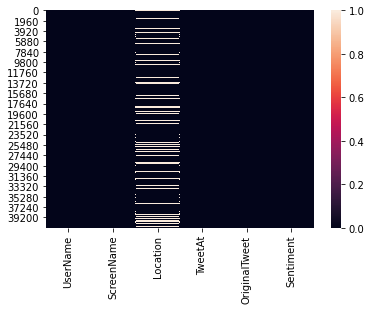

In [ ]:
# checking for null values in training data
sns.heatmap(train_df.isnull())

In [ ]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


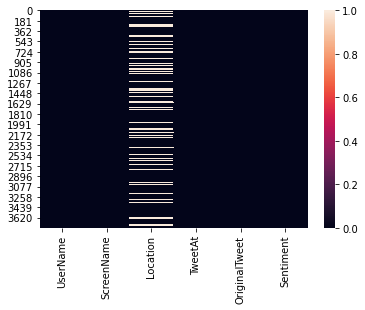

In [ ]:
# checking for null values in test data
sns.heatmap(test_df.isnull())

*Only the location column has null values in both the training and test data*

In [ ]:
print('Train dataset shape: ', train_df.shape)
print('Test dataset shape: ', test_df.shape)

Train dataset shape:  (41157, 6)
Test dataset shape:  (3798, 6)


####Exploratory Data Analysis

*Looking at the TweetAt column*

In [ ]:
# convert to datetime object
train_df['TweetAt'] = pd.to_datetime(train_df['TweetAt'])

**Visualizing tweets by month of the year**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


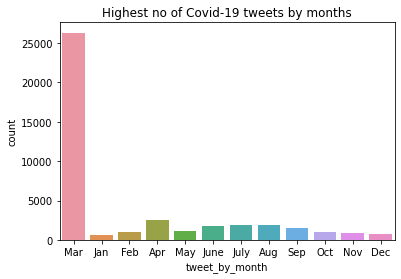

In [ ]:
train_df['tweet_by_month'] =  train_df['TweetAt'].apply(lambda x: x.month)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'June', 7: 'July', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# mapping the month name to its corresponding number
train_df['tweet_by_month'] = train_df['tweet_by_month'].map(month_map)
plt.title('Highest no of Covid-19 tweets by months')
sns.countplot('tweet_by_month', data=train_df)
plt.show()

The plot shows majority of the tweets were generated in March

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


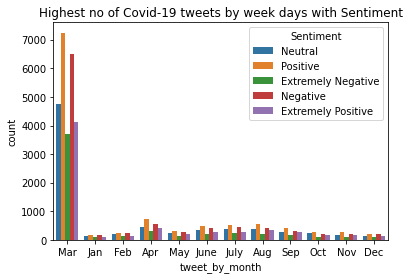

In [ ]:
plt.title('Highest no of Covid-19 tweets by week days with Sentiment')
sns.countplot('tweet_by_month', hue='Sentiment', data=train_df)
plt.show()

This shows that majority of tweets that occured in March had Positive sentiment

**Visualizing tweets by days of the week**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


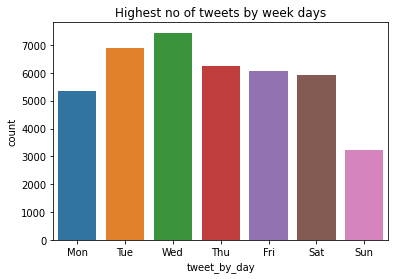

In [ ]:
train_df['tweet_by_day'] =  train_df['TweetAt'].apply(lambda x: x.dayofweek)
day_map = {0: 'Mon', 1: 'Tue', 2:'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
# mapping the month name to its corresponding number
train_df['tweet_by_day'] = train_df['tweet_by_day'].map(day_map)
plt.title('Highest no of tweets by week days')
sns.countplot('tweet_by_day', data=train_df)
plt.show()

The plot shows majority of the tweets were generated on a Wednesday

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


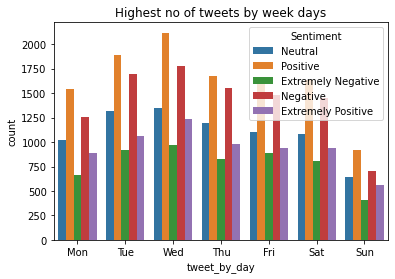

In [ ]:
plt.title('Highest no of tweets by week days with sentiment')
sns.countplot('tweet_by_day', hue='Sentiment', data=train_df)
plt.show()

This shows that majority of tweets that occured on Wednesdays had Positive sentiment

*Looking at the Location column*

In [ ]:
train_df['Location'].value_counts()[:20]

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
England, United Kingdom    191
Canada                     191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
Name: Location, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


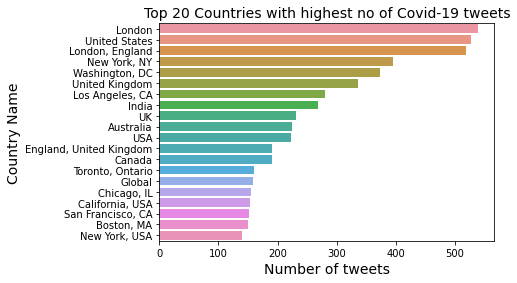

In [ ]:
# plotting the top 20 locations with highest no of covid-19 tweets
sns.barplot(train_df["Location"].value_counts().values[:20],
            train_df["Location"].value_counts().index[:20])
plt.title("Top 20 Countries with highest no of Covid-19 tweets", fontsize=14)
plt.xlabel("Number of tweets", fontsize=14)
plt.ylabel("Country Name", fontsize=14)
plt.show()


*Looking at the Sentiment column*

In [ ]:
train_df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

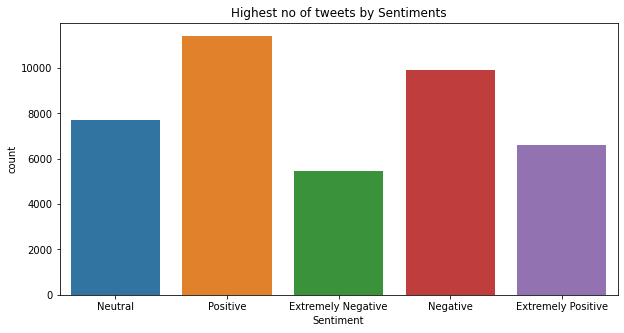

In [ ]:
plt.figure(figsize=[10,5])
plt.title('Highest no of tweets by Sentiments')
sns.countplot(x = "Sentiment", data = train_df)

Most of the tweets displayed a Positive sentiment

We will group the positive and extremely positive together and do the same for the negative and extremely negative sentiments

In [ ]:
# mapping negative as 0, neutral as 1 and positive as 2
sent_map = {'Extremely Negative':0, 'Negative':0, 'Neutral':1, 'Positive':2, 'Extremely Positive':2}
# create new column 
train_df['labels'] = train_df['Sentiment'].map(sent_map)
test_df['labels'] = test_df['Sentiment'].map(sent_map)

In [ ]:
# looking at the distribution of the target variable
train_df.labels.value_counts()

2    18046
0    15398
1     7713
Name: labels, dtype: int64

Text(0.5, 0, 'Sentiment')

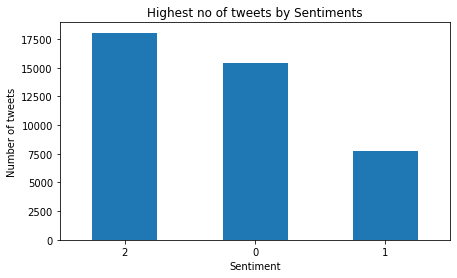

In [ ]:
# plot of tweet count against sentiment
train_df.labels.value_counts().plot.bar(figsize=(7,4))
plt.xticks(rotation=None)
plt.title('Highest no of tweets by Sentiments')
plt.ylabel('Number of tweets')
plt.xlabel('Sentiment')

Label 2 which represents the positive sentiment has the highest number of covid-19 tweets

####Data Cleaning and Preprocessing

In [ ]:
# assigning the relevant columns required
train_df = train_df[['OriginalTweet', 'labels']]
test_df = test_df[['OriginalTweet', 'labels']]

In [ ]:
train_df.head()

,OriginalTweet,labels
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,advice Talk to your neighbours family to excha...,2
2,Coronavirus Australia: Woolworths to give elde...,2
3,My food stock is not the only one which is emp...,2
4,"Me, ready to go at supermarket during the #COV...",0


In [ ]:
# to see the type of characters contained in the tweets
for i in range(5):
  print('Tweet {}'.format(1+i))
  print(train_df.OriginalTweet[i])
  print('\n')

Tweet 1
@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


Tweet 2
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order


Tweet 3
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P


Tweet 4





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j


Tweet 5




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n




Testing the regex functions to clean the data on a single tweet

In [ ]:
rev = re.sub(r'http\S+', " ",train_df.OriginalTweet[987])
rev

'????? ????? ?? ?????? ????? ??? ?? ??? ?? ???? ??? ??? ????? ?????????? ????? ????? ??? ????? ?? ???? ??????? ??? ??? \r\r\n#sindh government spokesman @murtazawahab1 terms #Quarantine facilities at #Taftaan border a joke. Watch the exclusive visuals of criminal negligence ??  '

In [ ]:
rev = re.sub(r'#\w+', ' ', rev)
rev

'????? ????? ?? ?????? ????? ??? ?? ??? ?? ???? ??? ??? ????? ?????????? ????? ????? ??? ????? ?? ???? ??????? ??? ??? \r\r\n  government spokesman @murtazawahab1 terms   facilities at   border a joke. Watch the exclusive visuals of criminal negligence ??  '

In [ ]:
rev = re.sub(r'@\w+', ' ', rev)
rev

'????? ????? ?? ?????? ????? ??? ?? ??? ?? ???? ??? ??? ????? ?????????? ????? ????? ??? ????? ?? ???? ??????? ??? ??? \r\r\n  government spokesman   terms   facilities at   border a joke. Watch the exclusive visuals of criminal negligence ??  '

In [ ]:
rev = re.sub('[^a-zA-Z]', ' ', rev)
rev

'                                                                                                                           government spokesman   terms   facilities at   border a joke  Watch the exclusive visuals of criminal negligence     '

In [ ]:
rev = rev.lower().split()
rev

['government',
 'spokesman',
 'terms',
 'facilities',
 'at',
 'border',
 'a',
 'joke',
 'watch',
 'the',
 'exclusive',
 'visuals',
 'of',
 'criminal',
 'negligence']

*We would need to remove url links, hash tags, @ tags, punctuations and all other characters except a-z*

In [ ]:
# create stemmer and lemmatizer objects
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# function to clean the data
def preprocess_clean_data(data, sl):
  corpus = [] # list to store all the cleaned text
  for i in range(len(data)):
    # removes urls
    review = re.sub(r'http\S+', " ", data.OriginalTweet[i])
    # remove #tags
    review = re.sub(r'#\w+', ' ', review)
    # remove @tags/mentions
    review = re.sub(r'@\w+', ' ', review)
    # remove characters apart from a-z and A-Z with spaces in each sentence
    review = re.sub('[^a-zA-Z]', ' ', review)
    # put each sentence in lower case
    review = review.lower()
    # split to get list of words
    review = review.split()
    if sl == 'stem':
      # apply stemming on the words
      review = [stemmer.stem(word) for word in review if word not in set(stopwords.words('english'))]
    else:
      # apply stemming on the words
      review = [lemmatizer.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    # join the words and convert back to a sentence
    review = ' '.join(review)
    corpus.append(review)

  return corpus

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# make a copy of both train and test data
train_stem_df = train_df.copy()
test_stem_df = test_df.copy()
train_lem_df = train_df.copy()
test_lem_df = test_df.copy()

####Using Stemming

In [ ]:
# cleaning the train data
train_stem_df['OriginalTweet'] = preprocess_clean_data(train_df, 'stem')
train_stem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   labels         41157 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 643.2+ KB


In [ ]:
# to clear and free up space in memory
gc.collect()

7

In [ ]:
# cleaning the test data
test_stem_df['OriginalTweet'] = preprocess_clean_data(test_df, 'stem')
test_stem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3798 non-null   object
 1   labels         3798 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.5+ KB


In [ ]:
gc.collect()

0

#####**Modelling the Data** 

#####Using Logistic Regression

In [ ]:
# sampling 32000 observations to use
train_stem_df = train_stem_df.sample(32000, random_state=42)

In [ ]:
# assign features X
X_train = train_stem_df['OriginalTweet']
X_train.shape

(32000,)

In [ ]:
# assign label, y
y_train = train_stem_df['labels']
y_train.shape

(32000,)

In [ ]:
X_test = test_stem_df['OriginalTweet']
y_test = test_stem_df['labels']
# checking the shape
X_test.shape, y_test.shape

((3798,), (3798,))

In [ ]:
gc.collect()

0

#####Using Bag of words as vectorizer

In [ ]:
# create bag of words
cv = CountVectorizer(max_features=30000) # max features gives the no of words you want to use as no of columns
cv.fit(X_train)
# transform train, validation and test data
X_train_cv = cv.transform(X_train).toarray()
print(X_train_cv.shape)
X_test_cv = cv.transform(X_test).toarray()
print(X_test_cv.shape)

(32000, 19863)
(3798, 19863)


In [ ]:
gc.collect()

0

In [ ]:
# create the model
model_lr = LogisticRegression(solver='saga', C=1, penalty='l1', random_state=42)
# fit the data
model_lr.fit(X_train_cv, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
gc.collect()

24

In [ ]:
# make prediction on the test data
y_pred = model_lr.predict(X_test_cv)

print('Accuracy on test data: ', accuracy_score(y_test, y_pred))

Accuracy on test data:  0.822538177988415


In [ ]:
gc.collect()

0

*Classification report using Confusion matrix*

In [ ]:
# using confusion matrix
# This function prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Classification report
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1633
           1       0.73      0.79      0.76       619
           2       0.83      0.85      0.84      1546

    accuracy                           0.82      3798
   macro avg       0.80      0.82      0.81      3798
weighted avg       0.82      0.82      0.82      3798

Confusion matrix, without normalization
[[1312   71  163]
 [  66  490   63]
 [ 197  114 1322]]


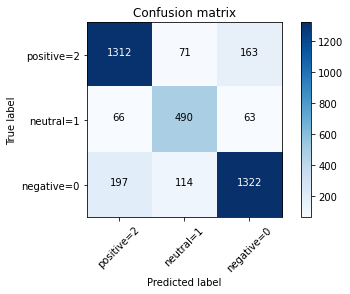

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 1, 0])
np.set_printoptions(precision=2)

print('Classification report')
print(classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive=2', 'neutral=1', 'negative=0'], normalize=False, title='Confusion matrix')


In [ ]:
gc.collect()

4060

#####Using TFIDF as the vectorizer

In [ ]:
# create bag of words
tfidf = TfidfVectorizer(max_features=30000) # max features gives the no of words you want to use as no of columns
tfidf.fit(X_train)
# transform train, validation and test data
X_train_tfidf = tfidf.transform(X_train).toarray()
print(X_train_tfidf.shape)
X_test_tfidf = tfidf.transform(X_test).toarray()
print(X_test_tfidf.shape)

(32000, 19863)
(3798, 19863)


In [ ]:
gc.collect()

0

In [ ]:
# create the model
model_lr_tfidf = LogisticRegression(solver='saga', C=1, penalty='l1', random_state=42)
# fit the data
model_lr_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
gc.collect()

0

In [ ]:
# make prediction on the test data
y_pred = model_lr_tfidf.predict(X_test_tfidf)

print('Accuracy on test data: ', accuracy_score(y_test, y_pred))


Accuracy on test data:  0.8288572933122696


In [ ]:
gc.collect()

0

*Classification report using Confusion matrix*

Classification report
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1633
           1       0.73      0.78      0.76       619
           2       0.84      0.86      0.85      1546

    accuracy                           0.83      3798
   macro avg       0.81      0.82      0.81      3798
weighted avg       0.83      0.83      0.83      3798

Confusion matrix, without normalization
[[1335   62  149]
 [  68  483   68]
 [ 188  115 1330]]


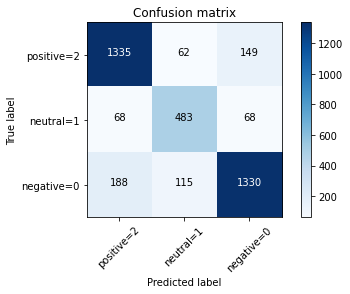

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 1, 0])
np.set_printoptions(precision=2)

print('Classification report')
print(classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive=2', 'neutral=1', 'negative=0'], normalize=False, title='Confusion matrix')


In [ ]:
gc.collect()

4060

In [ ]:
gc.collect()

4060

**We can see that using the TFIDF Vectorizer as the vectorizer gave better model performance with an accuracy of 82.8%**

####Using Lemmatization

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# cleaning the train data
train_lem_df['OriginalTweet'] = preprocess_clean_data(train_df, 'lem')
train_lem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   labels         41157 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 643.2+ KB


In [ ]:
gc.collect()

7

In [ ]:
# cleaning the test data
test_lem_df['OriginalTweet'] = preprocess_clean_data(test_df, 'lem')
test_lem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  3798 non-null   object
 1   labels         3798 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 59.5+ KB


In [ ]:
gc.collect()

0

Visualizing the text using Word cloud

In [ ]:
# function to display wordcloud 
def show_wordcloud(text_str):
    wc = WordCloud(max_words=500, width=600, height=300, random_state=42, stopwords=stop_words).generate(text_str)
    fig=plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wc)
    plt.show()

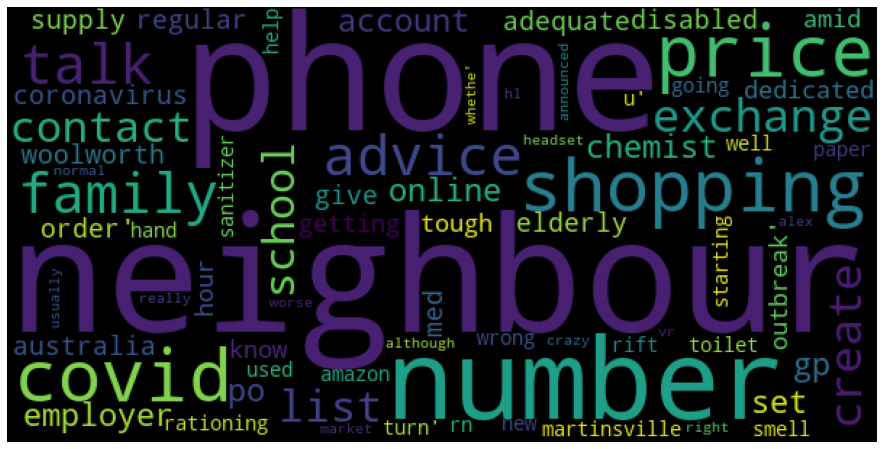

In [ ]:
# for train data
stop_words = set(STOPWORDS)
text = str(train_lem_df.OriginalTweet.values)
show_wordcloud(text)

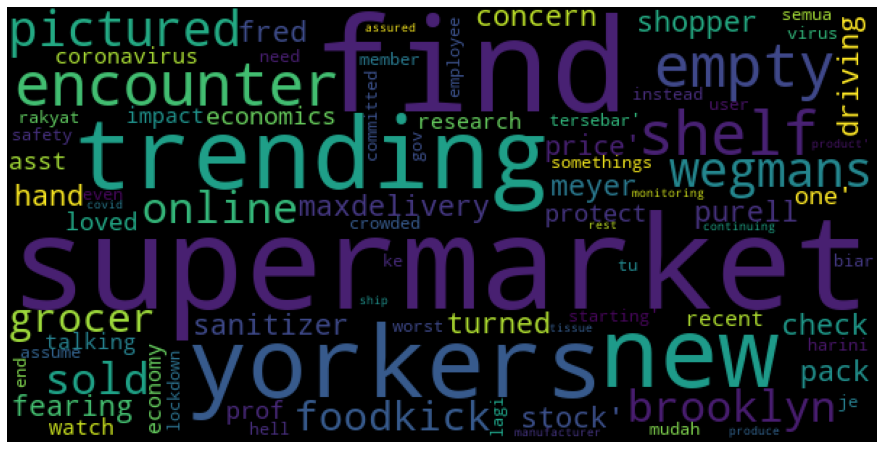

In [ ]:
# for test data
stop_words = set(STOPWORDS)
text = str(test_lem_df.OriginalTweet.values)
show_wordcloud(text)

#####**Modelling the Data** 

#####Using Logistic Regression

In [ ]:
# sampling 27k observations to use
train_lem_df = train_lem_df.sample(27000, random_state=42)

In [ ]:
# assign features X
X_train = train_lem_df['OriginalTweet']
X_train.shape

(27000,)

In [ ]:
# assign label, y
y_train = train_lem_df['labels']
y_train.shape

(27000,)

In [ ]:
X_test = test_lem_df['OriginalTweet']
y_test = test_lem_df['labels']
# checking the shape
X_test.shape, y_test.shape

((3798,), (3798,))

In [ ]:
gc.collect()

0

#####Using Bag of words as vectorizer

In [ ]:
# create bag of words
cv = CountVectorizer(max_features=25000) # max features gives the no of words you want to use as no of columns
cv.fit(X_train)
# transform train, validation and test data
X_train_cv = cv.transform(X_train).toarray()
print(X_train_cv.shape)
X_test_cv = cv.transform(X_test).toarray()
print(X_test_cv.shape)

(27000, 23410)
(3798, 23410)


In [ ]:
gc.collect()

0

In [ ]:
# create the model
model_lr = LogisticRegression(solver='saga', C=1, penalty='l1', random_state=42)
# fit the data
model_lr.fit(X_train_cv, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
gc.collect()

24

In [ ]:
# make prediction on the test data
y_pred = model_lr.predict(X_test_cv)

print('Accuracy on test data: ', accuracy_score(y_test, y_pred))


Accuracy on test data:  0.8275408109531333


In [ ]:
gc.collect()

0

*Classification report using Confusion matrix*

Classification report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1633
           1       0.72      0.79      0.76       619
           2       0.84      0.85      0.85      1546

    accuracy                           0.83      3798
   macro avg       0.81      0.82      0.81      3798
weighted avg       0.83      0.83      0.83      3798

Confusion matrix, without normalization
[[1319   72  155]
 [  66  492   61]
 [ 185  116 1332]]


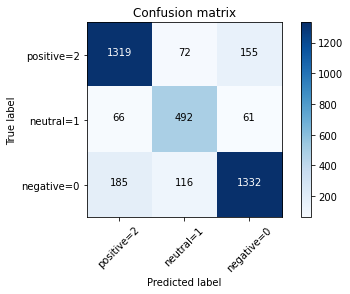

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 1, 0])
np.set_printoptions(precision=2)

print('Classification report')
print(classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive=2', 'neutral=1', 'negative=0'], normalize=False, title='Confusion matrix')


In [ ]:
gc.collect()

4060

#####Using TFIDF as the vectorizer

In [ ]:
# create bag of words
tfidf = TfidfVectorizer(max_features=20000) # max features gives the no of words you want to use as no of columns
tfidf.fit(X_train)
# transform train, validation and test data
X_train_tfidf = tfidf.transform(X_train).toarray()
print(X_train_tfidf.shape)
# X_val_cv = cv.transform(X_val).toarray()
# print(X_val.shape)
X_test_tfidf = tfidf.transform(X_test).toarray()
print(X_test_tfidf.shape)

(27000, 20000)
(3798, 20000)


In [ ]:
gc.collect()

0

In [ ]:
# create the model
model_lr_tfidf = LogisticRegression(solver='saga', C=1, penalty='l1', random_state=42)
# fit the data
model_lr_tfidf.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
gc.collect()

24

In [ ]:
gc.collect()

0

In [ ]:
# make prediction on the test data
y_pred = model_lr_tfidf.predict(X_test_tfidf)

print('Accuracy on test data: ', accuracy_score(y_test, y_pred))

Accuracy on test data:  0.8251711427066877


In [ ]:
gc.collect()

0

*Classification report using Confusion matrix*

Classification report
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1633
           1       0.73      0.81      0.76       619
           2       0.84      0.86      0.85      1546

    accuracy                           0.83      3798
   macro avg       0.81      0.82      0.81      3798
weighted avg       0.83      0.83      0.83      3798

Confusion matrix, without normalization
[[1323   65  158]
 [  53  500   66]
 [ 198  124 1311]]


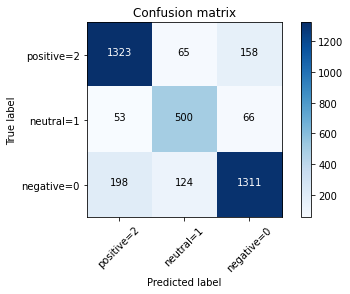

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 1, 0])
np.set_printoptions(precision=2)

print('Classification report')
print(classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive=2', 'neutral=1', 'negative=0'], normalize=False, title='Confusion matrix')


In [ ]:
gc.collect()

0

**We can see that using the Bag of Words as the vectorizer gave better model performance with an accuracy of 82.75%**

######**Looking at the Logistic regression models built using the Stemmer and Lemmatizer, the Stemmer model achieved a slighty better accuracy**

#####Using LSTM

In [ ]:
# observing the train data
train_tweets = train_lem_df.OriginalTweet.values
print(train_tweets[:5])
train_labels = train_lem_df.labels.values
train_labels[:5]

[''
 'advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order'
 'coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid outbreak'
 'food stock one empty please panic enough food everyone take need stay calm stay safe'
 'ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic cause shortage']


array([1, 2, 2, 2, 0])

In [ ]:
# observing the test data
test_tweets = test_lem_df.OriginalTweet.values
print(test_tweets[:5])
test_labels = test_lem_df.labels.values
test_labels[:5]

['trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn sold online grocer foodkick maxdelivery fearing shopper stock'
 'find hand sanitizer fred meyer turned pack purell check concern driving price'
 'find protect loved one'
 'buying hit city anxious shopper stock food amp medical supply worker becomes st confirmed patient staged event'
 'one week everyone buying baby milk powder next everyone buying toilet paper']


array([0, 2, 2, 0, 1])

In [ ]:
# import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# tokenize the dataset
# hyper parameters
vocab_size = 5000  # 10000 5000
embedding_dim = 16
max_length = 120  # 120 164
trunc_type = 'post'
pad_type = 'post'
oov_tok = '<OOV>'

# create the tokenizer
t = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenize the training tweets data
t.fit_on_texts(train_tweets)
word_index = t.word_index 
vocab_size = len(word_index) + 1
t_seq = t.texts_to_sequences(train_tweets)
train_seq_pad = pad_sequences(t_seq, maxlen=max_length, padding=pad_type, truncating=trunc_type)

test_seq = t.texts_to_sequences(test_tweets)
test_seq_pad = pad_sequences(test_seq, maxlen=max_length, padding=pad_type)

In [ ]:
# split train 
train_seq_pad, val_seq_pad, train_labels, val_labels = train_test_split(train_seq_pad, train_labels, test_size=0.2, random_state=42)
train_seq_pad.shape, val_seq_pad.shape, train_labels.shape, val_labels.shape

((32925, 120), (8232, 120), (32925,), (8232,))

In [ ]:
# model using bidirectional LSTM
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_bidi_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_bidi_lstm.summary()

# setting early stopping callback to help prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)
# setting model checkpoint to save the best model weights 
mc = ModelCheckpoint('final_model.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

# to train the model
EPOCHS = 10
history = model_bidi_lstm.fit(
    train_seq_pad,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_seq_pad, val_labels),
    verbose=2, 
    callbacks=[es, mc])

test_loss, test_accuracy = model_bidi_lstm.evaluate(test_seq_pad, test_labels)
print('Accuracy on test dataset: ', test_accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           459744    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          41472     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4

In [ ]:
# make predictions on test data using the best model weights saved
model_bidi_lstm.load_weights('/content/final_model.hdf5')
test_loss, test_accuracy = model_bidi_lstm.evaluate(test_seq_pad, test_labels)
print('Accuracy on test data: ', test_accuracy)

119/119 [==============================] - 3s 22ms/step - loss: 0.4595 - accuracy: 0.8447
Accuracy on test data:  0.8446550965309143


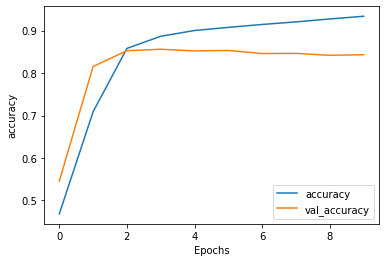

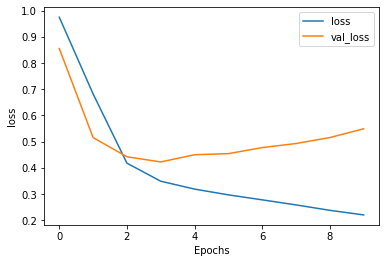

In [ ]:
# to visualize accuracy and loss 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "accuracy")  # to plot the accuracy and val accuracy
plot_graphs(history, "loss")  # to plot loss and val_loss

Plotting the embedding vectors in 3D space

In [ ]:
import io
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# to get the weights from the embedding layer(layer 0)
e = model_bidi_lstm.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

# Write out the embedding vectors and metadata
out_v = io.open('vecs2.tsv', 'w', encoding='utf-8')
out_m = io.open('meta2.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(28734, 16)


*These files (vecs2.tsv and meta2.tsv) can be downloaded and rendered on http://projector.tensorflow.org/*

In [ ]:
# model using multiple bidirectional LSTM
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_multiple_bidi_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_multiple_bidi_lstm.summary()

# setting early stopping callback to help prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)
# setting model checkpoint to save the best model weights 
mc = ModelCheckpoint('final_model1.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

# to train the model
EPOCHS = 10
history = model_multiple_bidi_lstm.fit(
    train_seq_pad,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_seq_pad, val_labels),
    verbose=2, 
    callbacks=[es, mc])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           459744    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 128)          41472     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32)                18560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [ ]:
# make predictions on test data using the best model weights saved
model_multiple_bidi_lstm.load_weights('/content/final_model1.hdf5')
test_loss, test_accuracy = model_multiple_bidi_lstm.evaluate(test_seq_pad, test_labels)
print('Accuracy on test data: ', test_accuracy)

119/119 [==============================] - 4s 36ms/step - loss: 0.5011 - accuracy: 0.8341
Accuracy on test data:  0.8341231942176819


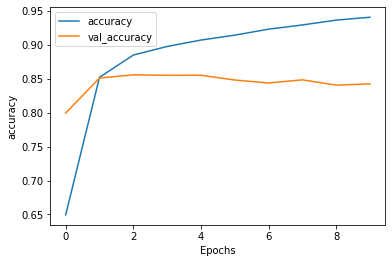

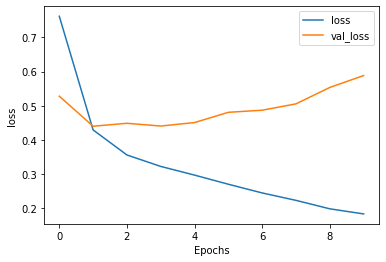

In [ ]:
# to visualize accuracy and loss 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "accuracy")  # to plot the accuracy and val accuracy
plot_graphs(history, "loss")  # to plot loss and val_loss

Plotting the embedding vectors in 3D space

In [ ]:
import io
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# to get the weights from the embedding layer(layer 0)
e = model_multiple_bidi_lstm.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

# Write out the embedding vectors and metadata
out_v = io.open('vecs1.tsv', 'w', encoding='utf-8')
out_m = io.open('meta1.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(28734, 16)


*These files (vecs1.tsv and meta1.tsv) can be downloaded and rendered on http://projector.tensorflow.org/*

##From all the models built, the single bidirectional LSTM model performed the best on the test data with an accuracy of 84.5%
These values can be improved further with various hyper parameter tuning and Transfer Learning.